# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=True) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=torch.randn(w[0].shape).cuda()*0.01
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel//2,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel//2,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        
        if a>0.37:
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.316704, Accuracy: 7.81
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.353208, Accuracy: 7.81
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.299966, Accuracy: 10.16
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.243143, Accuracy: 12.11
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.133137, Accuracy: 17.97
Train Epoch: 0 [6400/50000 (14%)]	Loss: 1.998923, Accuracy: 18.75
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.116172, Accuracy: 18.36
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.136685, Accuracy: 13.28
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.061302, Accuracy: 17.19
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.919407, Accuracy: 27.34
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.915111, Accuracy: 25.78
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.018020, Accuracy: 17.19
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.990862, Accuracy: 22.66
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.868446, Accuracy: 23.83
Train Epoch: 0 [17920/50000 (40%)]	Loss: 1.933813, Accuracy: 21.09
Train Epoch:

Train Epoch: 3 [14080/50000 (31%)]	Loss: 0.973045, Accuracy: 66.02
Train Epoch: 3 [15360/50000 (34%)]	Loss: 0.970531, Accuracy: 66.80
Train Epoch: 3 [16640/50000 (37%)]	Loss: 1.078942, Accuracy: 62.50
Train Epoch: 3 [17920/50000 (40%)]	Loss: 0.980111, Accuracy: 64.45
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.004504, Accuracy: 66.80
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.072742, Accuracy: 62.11
Train Epoch: 3 [21760/50000 (48%)]	Loss: 0.958648, Accuracy: 66.41
Train Epoch: 3 [23040/50000 (51%)]	Loss: 0.969537, Accuracy: 66.02
Train Epoch: 3 [24320/50000 (54%)]	Loss: 0.966663, Accuracy: 65.23
Train Epoch: 3 [25600/50000 (57%)]	Loss: 1.027152, Accuracy: 65.62
Train Epoch: 3 [26880/50000 (60%)]	Loss: 0.933597, Accuracy: 69.14
Train Epoch: 3 [28160/50000 (62%)]	Loss: 1.016932, Accuracy: 66.02
Train Epoch: 3 [29440/50000 (65%)]	Loss: 1.018487, Accuracy: 61.72
Train Epoch: 3 [30720/50000 (68%)]	Loss: 0.984311, Accuracy: 66.41
Train Epoch: 3 [32000/50000 (71%)]	Loss: 1.079893, Accuracy: 6

Train Epoch: 6 [26880/50000 (60%)]	Loss: 0.781744, Accuracy: 74.22
Train Epoch: 6 [28160/50000 (62%)]	Loss: 0.702936, Accuracy: 75.39
Train Epoch: 6 [29440/50000 (65%)]	Loss: 0.698285, Accuracy: 76.17
Train Epoch: 6 [30720/50000 (68%)]	Loss: 0.838803, Accuracy: 71.09
Train Epoch: 6 [32000/50000 (71%)]	Loss: 0.715902, Accuracy: 74.61
Train Epoch: 6 [33280/50000 (74%)]	Loss: 0.730193, Accuracy: 76.56
Train Epoch: 6 [34560/50000 (77%)]	Loss: 0.709040, Accuracy: 73.83
Train Epoch: 6 [35840/50000 (80%)]	Loss: 0.762147, Accuracy: 74.61
Train Epoch: 6 [37120/50000 (82%)]	Loss: 0.569397, Accuracy: 80.86
Train Epoch: 6 [38400/50000 (85%)]	Loss: 0.690112, Accuracy: 76.56
Train Epoch: 6 [39680/50000 (88%)]	Loss: 0.705382, Accuracy: 74.22
Train Epoch: 6 [40960/50000 (91%)]	Loss: 0.700689, Accuracy: 73.83
Train Epoch: 6 [42240/50000 (94%)]	Loss: 0.694677, Accuracy: 76.56
Train Epoch: 6 [43520/50000 (97%)]	Loss: 0.667818, Accuracy: 76.95
Train Epoch: 6 [35000/50000 (99%)]	Loss: 0.554533, Accuracy: 8

Train Epoch: 9 [30720/50000 (68%)]	Loss: 0.449797, Accuracy: 86.33
Train Epoch: 9 [32000/50000 (71%)]	Loss: 0.679902, Accuracy: 75.78
Train Epoch: 9 [33280/50000 (74%)]	Loss: 0.541111, Accuracy: 83.98
Train Epoch: 9 [34560/50000 (77%)]	Loss: 0.544761, Accuracy: 83.59
Train Epoch: 9 [35840/50000 (80%)]	Loss: 0.656859, Accuracy: 76.95
Train Epoch: 9 [37120/50000 (82%)]	Loss: 0.628509, Accuracy: 78.52
Train Epoch: 9 [38400/50000 (85%)]	Loss: 0.576768, Accuracy: 78.12
Train Epoch: 9 [39680/50000 (88%)]	Loss: 0.624049, Accuracy: 82.03
Train Epoch: 9 [40960/50000 (91%)]	Loss: 0.631110, Accuracy: 78.52
Train Epoch: 9 [42240/50000 (94%)]	Loss: 0.583086, Accuracy: 80.08
Train Epoch: 9 [43520/50000 (97%)]	Loss: 0.617956, Accuracy: 79.30
Train Epoch: 9 [35000/50000 (99%)]	Loss: 0.559871, Accuracy: 82.00

Validation set: Average loss: 0.7001, Accuracy: 3851/5000 (77.00%)

the time of this epoch:[36.513710737228394 s]
Train Epoch: 10 [0/50000 (0%)]	Loss: 0.541178, Accuracy: 81.25
Train Epoch: 10 [1

Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.580739, Accuracy: 81.64
Train Epoch: 12 [42240/50000 (94%)]	Loss: 0.464193, Accuracy: 84.38
Train Epoch: 12 [43520/50000 (97%)]	Loss: 0.564938, Accuracy: 81.64
Train Epoch: 12 [35000/50000 (99%)]	Loss: 0.528122, Accuracy: 82.50

Validation set: Average loss: 0.7271, Accuracy: 3820/5000 (76.00%)

the time of this epoch:[36.441784381866455 s]

Test set: Average loss: 0.7514, Accuracy: 7488/10000 (74.88%)

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.417827, Accuracy: 85.94
Train Epoch: 13 [1280/50000 (3%)]	Loss: 0.409086, Accuracy: 87.50
Train Epoch: 13 [2560/50000 (6%)]	Loss: 0.556519, Accuracy: 80.47
Train Epoch: 13 [3840/50000 (9%)]	Loss: 0.447745, Accuracy: 87.89
Train Epoch: 13 [5120/50000 (11%)]	Loss: 0.485698, Accuracy: 82.03
Train Epoch: 13 [6400/50000 (14%)]	Loss: 0.449324, Accuracy: 86.33
Train Epoch: 13 [7680/50000 (17%)]	Loss: 0.502645, Accuracy: 83.20
Train Epoch: 13 [8960/50000 (20%)]	Loss: 0.542426, Accuracy: 83.20
Train Epoch: 13 [102

Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.483176, Accuracy: 82.81
Train Epoch: 16 [2560/50000 (6%)]	Loss: 0.378925, Accuracy: 86.33
Train Epoch: 16 [3840/50000 (9%)]	Loss: 0.577422, Accuracy: 78.91
Train Epoch: 16 [5120/50000 (11%)]	Loss: 0.377858, Accuracy: 89.06
Train Epoch: 16 [6400/50000 (14%)]	Loss: 0.356640, Accuracy: 87.11
Train Epoch: 16 [7680/50000 (17%)]	Loss: 0.506118, Accuracy: 85.16
Train Epoch: 16 [8960/50000 (20%)]	Loss: 0.438998, Accuracy: 85.55
Train Epoch: 16 [10240/50000 (23%)]	Loss: 0.365598, Accuracy: 85.55
Train Epoch: 16 [11520/50000 (26%)]	Loss: 0.463216, Accuracy: 85.55
Train Epoch: 16 [12800/50000 (28%)]	Loss: 0.456161, Accuracy: 83.59
Train Epoch: 16 [14080/50000 (31%)]	Loss: 0.428328, Accuracy: 83.59
Train Epoch: 16 [15360/50000 (34%)]	Loss: 0.410391, Accuracy: 88.67
Train Epoch: 16 [16640/50000 (37%)]	Loss: 0.421642, Accuracy: 85.16
Train Epoch: 16 [17920/50000 (40%)]	Loss: 0.485967, Accuracy: 82.03
Train Epoch: 16 [19200/50000 (43%)]	Loss: 0.460820, Accura

Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.371770, Accuracy: 87.50
Train Epoch: 19 [11520/50000 (26%)]	Loss: 0.531536, Accuracy: 83.20
Train Epoch: 19 [12800/50000 (28%)]	Loss: 0.392761, Accuracy: 87.11
Train Epoch: 19 [14080/50000 (31%)]	Loss: 0.388224, Accuracy: 86.72
Train Epoch: 19 [15360/50000 (34%)]	Loss: 0.450161, Accuracy: 84.38
Train Epoch: 19 [16640/50000 (37%)]	Loss: 0.420607, Accuracy: 85.16
Train Epoch: 19 [17920/50000 (40%)]	Loss: 0.488286, Accuracy: 82.03
Train Epoch: 19 [19200/50000 (43%)]	Loss: 0.523002, Accuracy: 82.42
Train Epoch: 19 [20480/50000 (45%)]	Loss: 0.316246, Accuracy: 89.45
Train Epoch: 19 [21760/50000 (48%)]	Loss: 0.440568, Accuracy: 85.55
Train Epoch: 19 [23040/50000 (51%)]	Loss: 0.383295, Accuracy: 88.28
Train Epoch: 19 [24320/50000 (54%)]	Loss: 0.537066, Accuracy: 83.59
Train Epoch: 19 [25600/50000 (57%)]	Loss: 0.430065, Accuracy: 85.94
Train Epoch: 19 [26880/50000 (60%)]	Loss: 0.370623, Accuracy: 87.11
Train Epoch: 19 [28160/50000 (62%)]	Loss: 0.4648

Train Epoch: 22 [20480/50000 (45%)]	Loss: 0.425796, Accuracy: 84.38
Train Epoch: 22 [21760/50000 (48%)]	Loss: 0.419174, Accuracy: 85.94
Train Epoch: 22 [23040/50000 (51%)]	Loss: 0.408738, Accuracy: 85.94
Train Epoch: 22 [24320/50000 (54%)]	Loss: 0.467688, Accuracy: 83.98
Train Epoch: 22 [25600/50000 (57%)]	Loss: 0.384958, Accuracy: 87.50
Train Epoch: 22 [26880/50000 (60%)]	Loss: 0.442602, Accuracy: 83.59
Train Epoch: 22 [28160/50000 (62%)]	Loss: 0.388100, Accuracy: 86.33
Train Epoch: 22 [29440/50000 (65%)]	Loss: 0.432566, Accuracy: 85.94
Train Epoch: 22 [30720/50000 (68%)]	Loss: 0.396259, Accuracy: 87.50
Train Epoch: 22 [32000/50000 (71%)]	Loss: 0.358817, Accuracy: 89.06
Train Epoch: 22 [33280/50000 (74%)]	Loss: 0.404589, Accuracy: 85.94
Train Epoch: 22 [34560/50000 (77%)]	Loss: 0.398503, Accuracy: 84.77
Train Epoch: 22 [35840/50000 (80%)]	Loss: 0.366166, Accuracy: 85.94
Train Epoch: 22 [37120/50000 (82%)]	Loss: 0.300754, Accuracy: 91.80
Train Epoch: 22 [38400/50000 (85%)]	Loss: 0.4241

Train Epoch: 25 [29440/50000 (65%)]	Loss: 0.323404, Accuracy: 88.67
Train Epoch: 25 [30720/50000 (68%)]	Loss: 0.448584, Accuracy: 86.72
Train Epoch: 25 [32000/50000 (71%)]	Loss: 0.430042, Accuracy: 85.55
Train Epoch: 25 [33280/50000 (74%)]	Loss: 0.507318, Accuracy: 84.77
Train Epoch: 25 [34560/50000 (77%)]	Loss: 0.449295, Accuracy: 85.55
Train Epoch: 25 [35840/50000 (80%)]	Loss: 0.394930, Accuracy: 88.67
Train Epoch: 25 [37120/50000 (82%)]	Loss: 0.375777, Accuracy: 85.94
Train Epoch: 25 [38400/50000 (85%)]	Loss: 0.489016, Accuracy: 83.59
Train Epoch: 25 [39680/50000 (88%)]	Loss: 0.405104, Accuracy: 85.16
Train Epoch: 25 [40960/50000 (91%)]	Loss: 0.333655, Accuracy: 89.45
Train Epoch: 25 [42240/50000 (94%)]	Loss: 0.477311, Accuracy: 85.55
Train Epoch: 25 [43520/50000 (97%)]	Loss: 0.416453, Accuracy: 85.55
Train Epoch: 25 [35000/50000 (99%)]	Loss: 0.501366, Accuracy: 83.50

Validation set: Average loss: 0.6879, Accuracy: 3942/5000 (78.00%)

the time of this epoch:[39.627936124801636 s]
T

Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.406620, Accuracy: 87.11
Train Epoch: 28 [26880/50000 (60%)]	Loss: 0.445504, Accuracy: 83.59
Train Epoch: 28 [28160/50000 (62%)]	Loss: 0.391240, Accuracy: 88.28
Train Epoch: 28 [29440/50000 (65%)]	Loss: 0.366822, Accuracy: 89.45
Train Epoch: 28 [30720/50000 (68%)]	Loss: 0.409954, Accuracy: 86.33
Train Epoch: 28 [32000/50000 (71%)]	Loss: 0.497617, Accuracy: 83.98
Train Epoch: 28 [33280/50000 (74%)]	Loss: 0.435051, Accuracy: 83.59
Train Epoch: 28 [34560/50000 (77%)]	Loss: 0.468059, Accuracy: 85.16
Train Epoch: 28 [35840/50000 (80%)]	Loss: 0.466041, Accuracy: 84.38
Train Epoch: 28 [37120/50000 (82%)]	Loss: 0.462644, Accuracy: 84.38
Train Epoch: 28 [38400/50000 (85%)]	Loss: 0.541074, Accuracy: 81.64
Train Epoch: 28 [39680/50000 (88%)]	Loss: 0.418244, Accuracy: 88.28
Train Epoch: 28 [40960/50000 (91%)]	Loss: 0.386526, Accuracy: 89.45
Train Epoch: 28 [42240/50000 (94%)]	Loss: 0.334008, Accuracy: 89.45
Train Epoch: 28 [43520/50000 (97%)]	Loss: 0.4795

Train Epoch: 31 [34560/50000 (77%)]	Loss: 0.420852, Accuracy: 86.72
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.313451, Accuracy: 91.02
Train Epoch: 31 [37120/50000 (82%)]	Loss: 0.363924, Accuracy: 87.50
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.423118, Accuracy: 86.72
Train Epoch: 31 [39680/50000 (88%)]	Loss: 0.410131, Accuracy: 86.33
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.341584, Accuracy: 87.89
Train Epoch: 31 [42240/50000 (94%)]	Loss: 0.395404, Accuracy: 86.72
Train Epoch: 31 [43520/50000 (97%)]	Loss: 0.377728, Accuracy: 87.89
Train Epoch: 31 [35000/50000 (99%)]	Loss: 0.383232, Accuracy: 90.00

Validation set: Average loss: 0.5522, Accuracy: 4110/5000 (82.00%)

the time of this epoch:[39.55836629867554 s]
Train Epoch: 32 [0/50000 (0%)]	Loss: 0.368619, Accuracy: 88.67
Train Epoch: 32 [1280/50000 (3%)]	Loss: 0.389229, Accuracy: 87.11
Train Epoch: 32 [2560/50000 (6%)]	Loss: 0.362747, Accuracy: 87.11
Train Epoch: 32 [3840/50000 (9%)]	Loss: 0.364577, Accuracy: 88.28
Train Epoch: 

Train Epoch: 34 [38400/50000 (85%)]	Loss: 0.381778, Accuracy: 87.50
Train Epoch: 34 [39680/50000 (88%)]	Loss: 0.428820, Accuracy: 84.38
Train Epoch: 34 [40960/50000 (91%)]	Loss: 0.358834, Accuracy: 89.06
Train Epoch: 34 [42240/50000 (94%)]	Loss: 0.530289, Accuracy: 83.98
Train Epoch: 34 [43520/50000 (97%)]	Loss: 0.399432, Accuracy: 85.94
Train Epoch: 34 [35000/50000 (99%)]	Loss: 0.383538, Accuracy: 87.00

Validation set: Average loss: 0.6161, Accuracy: 3962/5000 (79.00%)

the time of this epoch:[36.29870104789734 s]

Test set: Average loss: 0.6155, Accuracy: 7971/10000 (79.71%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.386020, Accuracy: 88.67
Train Epoch: 35 [1280/50000 (3%)]	Loss: 0.321128, Accuracy: 89.84
Train Epoch: 35 [2560/50000 (6%)]	Loss: 0.325898, Accuracy: 89.45
Train Epoch: 35 [3840/50000 (9%)]	Loss: 0.360748, Accuracy: 85.94
Train Epoch: 35 [5120/50000 (11%)]	Loss: 0.368207, Accuracy: 87.50
Train Epoch: 35 [6400/50000 (14%)]	Loss: 0.339880, Accuracy: 89.06
Train Epoch: 35 [76

Train Epoch: 35 [33280/50000 (74%)]	Loss: 0.444279, Accuracy: 86.33
Train Epoch: 35 [34560/50000 (77%)]	Loss: 0.474252, Accuracy: 83.98
Train Epoch: 35 [35840/50000 (80%)]	Loss: 0.421689, Accuracy: 87.89
Train Epoch: 35 [37120/50000 (82%)]	Loss: 0.437137, Accuracy: 84.38
Train Epoch: 35 [38400/50000 (85%)]	Loss: 0.338578, Accuracy: 89.06
Train Epoch: 35 [39680/50000 (88%)]	Loss: 0.491081, Accuracy: 82.81
Train Epoch: 35 [40960/50000 (91%)]	Loss: 0.439332, Accuracy: 87.11
Train Epoch: 35 [42240/50000 (94%)]	Loss: 0.388331, Accuracy: 85.94
Train Epoch: 35 [43520/50000 (97%)]	Loss: 0.395103, Accuracy: 85.94
Train Epoch: 35 [35000/50000 (99%)]	Loss: 0.404540, Accuracy: 87.50

Validation set: Average loss: 0.7671, Accuracy: 3837/5000 (76.00%)

the time of this epoch:[39.43820571899414 s]
Train Epoch: 36 [0/50000 (0%)]	Loss: 0.444071, Accuracy: 85.16
Train Epoch: 36 [1280/50000 (3%)]	Loss: 0.375584, Accuracy: 86.72
Train Epoch: 36 [2560/50000 (6%)]	Loss: 0.377513, Accuracy: 86.72
Train Epoch

Train Epoch: 38 [43520/50000 (97%)]	Loss: 0.346661, Accuracy: 89.84
Train Epoch: 38 [35000/50000 (99%)]	Loss: 0.424610, Accuracy: 86.00

Validation set: Average loss: 0.6340, Accuracy: 4038/5000 (80.00%)

the time of this epoch:[36.32576942443848 s]

Test set: Average loss: 0.6389, Accuracy: 8017/10000 (80.17%)

Train Epoch: 39 [0/50000 (0%)]	Loss: 0.380700, Accuracy: 87.11
Train Epoch: 39 [1280/50000 (3%)]	Loss: 0.335637, Accuracy: 87.11
Train Epoch: 39 [2560/50000 (6%)]	Loss: 0.438443, Accuracy: 85.55
Train Epoch: 39 [3840/50000 (9%)]	Loss: 0.390839, Accuracy: 85.94
Train Epoch: 39 [5120/50000 (11%)]	Loss: 0.318189, Accuracy: 88.67
Train Epoch: 39 [6400/50000 (14%)]	Loss: 0.516025, Accuracy: 83.59
Train Epoch: 39 [7680/50000 (17%)]	Loss: 0.337853, Accuracy: 88.67
Train Epoch: 39 [8960/50000 (20%)]	Loss: 0.423792, Accuracy: 86.33
Train Epoch: 39 [10240/50000 (23%)]	Loss: 0.363144, Accuracy: 87.50
Train Epoch: 39 [11520/50000 (26%)]	Loss: 0.455338, Accuracy: 83.59
Train Epoch: 39 [1280

Train Epoch: 40 [28160/50000 (62%)]	Loss: 0.428981, Accuracy: 85.94
Train Epoch: 40 [29440/50000 (65%)]	Loss: 0.379405, Accuracy: 88.28
Train Epoch: 40 [30720/50000 (68%)]	Loss: 0.273812, Accuracy: 87.89
Train Epoch: 40 [32000/50000 (71%)]	Loss: 0.332366, Accuracy: 88.28
Train Epoch: 40 [33280/50000 (74%)]	Loss: 0.403153, Accuracy: 85.94
Train Epoch: 40 [34560/50000 (77%)]	Loss: 0.341865, Accuracy: 89.84
Train Epoch: 40 [35840/50000 (80%)]	Loss: 0.346085, Accuracy: 87.89
Train Epoch: 40 [37120/50000 (82%)]	Loss: 0.347020, Accuracy: 86.72
torch.Size([512, 1, 1])
tensor(1.00000e-02 *
       [[[-1.2742]],

        [[ 0.4832]],

        [[-0.4428]],

        [[ 0.5048]],

        [[-1.5582]],

        [[-0.8024]],

        [[ 0.1330]],

        [[-0.3628]],

        [[ 0.3957]],

        [[ 1.1911]],

        [[-0.9653]],

        [[-0.3029]],

        [[-0.4195]],

        [[-0.2816]],

        [[ 0.2637]],

        [[-1.0575]],

        [[-0.3826]],

        [[ 0.7469]],

        [[-0.14

Train Epoch: 40 [38400/50000 (85%)]	Loss: 0.416124, Accuracy: 85.55
Train Epoch: 40 [39680/50000 (88%)]	Loss: 0.357095, Accuracy: 89.06
Train Epoch: 40 [40960/50000 (91%)]	Loss: 0.385775, Accuracy: 88.67
Train Epoch: 40 [42240/50000 (94%)]	Loss: 0.467713, Accuracy: 86.33
Train Epoch: 40 [43520/50000 (97%)]	Loss: 0.350438, Accuracy: 88.28
Train Epoch: 40 [35000/50000 (99%)]	Loss: 0.411136, Accuracy: 85.00

Validation set: Average loss: 0.7424, Accuracy: 3846/5000 (76.00%)

the time of this epoch:[36.31203246116638 s]

Test set: Average loss: 0.7649, Accuracy: 7612/10000 (76.12%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.354475, Accuracy: 86.72
Train Epoch: 41 [1280/50000 (3%)]	Loss: 0.341551, Accuracy: 86.72
Train Epoch: 41 [2560/50000 (6%)]	Loss: 0.427171, Accuracy: 84.77
Train Epoch: 41 [3840/50000 (9%)]	Loss: 0.370378, Accuracy: 87.50
Train Epoch: 41 [5120/50000 (11%)]	Loss: 0.339996, Accuracy: 87.89
Train Epoch: 41 [6400/50000 (14%)]	Loss: 0.316873, Accuracy: 89.06
Train Epoch: 41 [76

Train Epoch: 44 [1280/50000 (3%)]	Loss: 0.244061, Accuracy: 91.02
Train Epoch: 44 [2560/50000 (6%)]	Loss: 0.416960, Accuracy: 86.33
Train Epoch: 44 [3840/50000 (9%)]	Loss: 0.350729, Accuracy: 88.67
Train Epoch: 44 [5120/50000 (11%)]	Loss: 0.280693, Accuracy: 91.41
Train Epoch: 44 [6400/50000 (14%)]	Loss: 0.352698, Accuracy: 88.28
Train Epoch: 44 [7680/50000 (17%)]	Loss: 0.327107, Accuracy: 89.06
Train Epoch: 44 [8960/50000 (20%)]	Loss: 0.316134, Accuracy: 89.06
Train Epoch: 44 [10240/50000 (23%)]	Loss: 0.413962, Accuracy: 86.33
Train Epoch: 44 [11520/50000 (26%)]	Loss: 0.356243, Accuracy: 88.67
Train Epoch: 44 [12800/50000 (28%)]	Loss: 0.432548, Accuracy: 86.72
Train Epoch: 44 [14080/50000 (31%)]	Loss: 0.304881, Accuracy: 89.84
Train Epoch: 44 [15360/50000 (34%)]	Loss: 0.361433, Accuracy: 87.50
Train Epoch: 44 [16640/50000 (37%)]	Loss: 0.391868, Accuracy: 87.50
torch.Size([512, 1, 1])
tensor(1.00000e-02 *
       [[[-1.7463]],

        [[-1.4881]],

        [[-0.3634]],

        [[ 0.00

Train Epoch: 44 [17920/50000 (40%)]	Loss: 0.354028, Accuracy: 88.28
Train Epoch: 44 [19200/50000 (43%)]	Loss: 0.380351, Accuracy: 83.98
Train Epoch: 44 [20480/50000 (45%)]	Loss: 0.420970, Accuracy: 85.94
Train Epoch: 44 [21760/50000 (48%)]	Loss: 0.313077, Accuracy: 89.45
Train Epoch: 44 [23040/50000 (51%)]	Loss: 0.336326, Accuracy: 89.45
Train Epoch: 44 [24320/50000 (54%)]	Loss: 0.412061, Accuracy: 85.55
Train Epoch: 44 [25600/50000 (57%)]	Loss: 0.380163, Accuracy: 86.72
Train Epoch: 44 [26880/50000 (60%)]	Loss: 0.354531, Accuracy: 87.50
Train Epoch: 44 [28160/50000 (62%)]	Loss: 0.342209, Accuracy: 87.50
Train Epoch: 44 [29440/50000 (65%)]	Loss: 0.356752, Accuracy: 88.67
Train Epoch: 44 [30720/50000 (68%)]	Loss: 0.375883, Accuracy: 85.16
Train Epoch: 44 [32000/50000 (71%)]	Loss: 0.394779, Accuracy: 86.33
Train Epoch: 44 [33280/50000 (74%)]	Loss: 0.505821, Accuracy: 83.20
Train Epoch: 44 [34560/50000 (77%)]	Loss: 0.346675, Accuracy: 87.89
Train Epoch: 44 [35840/50000 (80%)]	Loss: 0.3012

Train Epoch: 47 [26880/50000 (60%)]	Loss: 0.317204, Accuracy: 88.67
Train Epoch: 47 [28160/50000 (62%)]	Loss: 0.310041, Accuracy: 88.28
Train Epoch: 47 [29440/50000 (65%)]	Loss: 0.431742, Accuracy: 84.77
Train Epoch: 47 [30720/50000 (68%)]	Loss: 0.470243, Accuracy: 82.42
Train Epoch: 47 [32000/50000 (71%)]	Loss: 0.397431, Accuracy: 85.16
Train Epoch: 47 [33280/50000 (74%)]	Loss: 0.320095, Accuracy: 87.89
Train Epoch: 47 [34560/50000 (77%)]	Loss: 0.343816, Accuracy: 87.89
Train Epoch: 47 [35840/50000 (80%)]	Loss: 0.289495, Accuracy: 91.41
Train Epoch: 47 [37120/50000 (82%)]	Loss: 0.318600, Accuracy: 88.28
Train Epoch: 47 [38400/50000 (85%)]	Loss: 0.382570, Accuracy: 85.94
Train Epoch: 47 [39680/50000 (88%)]	Loss: 0.410666, Accuracy: 86.33
Train Epoch: 47 [40960/50000 (91%)]	Loss: 0.420128, Accuracy: 86.33
Train Epoch: 47 [42240/50000 (94%)]	Loss: 0.253924, Accuracy: 91.02
Train Epoch: 47 [43520/50000 (97%)]	Loss: 0.376117, Accuracy: 87.89
Train Epoch: 47 [35000/50000 (99%)]	Loss: 0.4267

Train Epoch: 49 [6400/50000 (14%)]	Loss: 0.305917, Accuracy: 91.02
Train Epoch: 49 [7680/50000 (17%)]	Loss: 0.339473, Accuracy: 89.84
Train Epoch: 49 [8960/50000 (20%)]	Loss: 0.355953, Accuracy: 86.33
Train Epoch: 49 [10240/50000 (23%)]	Loss: 0.364432, Accuracy: 87.89
Train Epoch: 49 [11520/50000 (26%)]	Loss: 0.310832, Accuracy: 89.45
Train Epoch: 49 [12800/50000 (28%)]	Loss: 0.410847, Accuracy: 85.55
Train Epoch: 49 [14080/50000 (31%)]	Loss: 0.458333, Accuracy: 86.33
Train Epoch: 49 [15360/50000 (34%)]	Loss: 0.383195, Accuracy: 86.72
Train Epoch: 49 [16640/50000 (37%)]	Loss: 0.357443, Accuracy: 85.94
Train Epoch: 49 [17920/50000 (40%)]	Loss: 0.547352, Accuracy: 82.42
Train Epoch: 49 [19200/50000 (43%)]	Loss: 0.394082, Accuracy: 85.55
Train Epoch: 49 [20480/50000 (45%)]	Loss: 0.376767, Accuracy: 88.28
Train Epoch: 49 [21760/50000 (48%)]	Loss: 0.404760, Accuracy: 84.77
Train Epoch: 49 [23040/50000 (51%)]	Loss: 0.349942, Accuracy: 87.89
Train Epoch: 49 [24320/50000 (54%)]	Loss: 0.319674,

Train Epoch: 52 [0/50000 (0%)]	Loss: 0.222598, Accuracy: 94.53
Train Epoch: 52 [1280/50000 (3%)]	Loss: 0.177667, Accuracy: 94.53
Train Epoch: 52 [2560/50000 (6%)]	Loss: 0.206838, Accuracy: 94.53
Train Epoch: 52 [3840/50000 (9%)]	Loss: 0.211075, Accuracy: 92.19
Train Epoch: 52 [5120/50000 (11%)]	Loss: 0.258330, Accuracy: 93.36
Train Epoch: 52 [6400/50000 (14%)]	Loss: 0.232898, Accuracy: 91.41
Train Epoch: 52 [7680/50000 (17%)]	Loss: 0.246294, Accuracy: 90.62
Train Epoch: 52 [8960/50000 (20%)]	Loss: 0.203024, Accuracy: 92.58
Train Epoch: 52 [10240/50000 (23%)]	Loss: 0.180972, Accuracy: 92.19
Train Epoch: 52 [11520/50000 (26%)]	Loss: 0.197220, Accuracy: 92.19
Train Epoch: 52 [12800/50000 (28%)]	Loss: 0.176596, Accuracy: 95.70
Train Epoch: 52 [14080/50000 (31%)]	Loss: 0.203454, Accuracy: 92.58
Train Epoch: 52 [15360/50000 (34%)]	Loss: 0.164606, Accuracy: 94.92
Train Epoch: 52 [16640/50000 (37%)]	Loss: 0.165068, Accuracy: 94.92
Train Epoch: 52 [17920/50000 (40%)]	Loss: 0.119501, Accuracy: 9

Train Epoch: 52 [28160/50000 (62%)]	Loss: 0.143575, Accuracy: 95.31
Train Epoch: 52 [29440/50000 (65%)]	Loss: 0.187122, Accuracy: 94.92
Train Epoch: 52 [30720/50000 (68%)]	Loss: 0.138403, Accuracy: 94.92
Train Epoch: 52 [32000/50000 (71%)]	Loss: 0.198952, Accuracy: 91.80
Train Epoch: 52 [33280/50000 (74%)]	Loss: 0.206495, Accuracy: 94.53
Train Epoch: 52 [34560/50000 (77%)]	Loss: 0.204260, Accuracy: 92.58
Train Epoch: 52 [35840/50000 (80%)]	Loss: 0.138287, Accuracy: 96.09
Train Epoch: 52 [37120/50000 (82%)]	Loss: 0.125252, Accuracy: 95.31
Train Epoch: 52 [38400/50000 (85%)]	Loss: 0.195272, Accuracy: 92.97
Train Epoch: 52 [39680/50000 (88%)]	Loss: 0.136558, Accuracy: 94.53
Train Epoch: 52 [40960/50000 (91%)]	Loss: 0.220269, Accuracy: 92.97
Train Epoch: 52 [42240/50000 (94%)]	Loss: 0.208675, Accuracy: 93.36
Train Epoch: 52 [43520/50000 (97%)]	Loss: 0.267932, Accuracy: 91.80
Train Epoch: 52 [35000/50000 (99%)]	Loss: 0.181334, Accuracy: 92.50

Validation set: Average loss: 0.2652, Accuracy:

Train Epoch: 55 [37120/50000 (82%)]	Loss: 0.140284, Accuracy: 96.48
Train Epoch: 55 [38400/50000 (85%)]	Loss: 0.130737, Accuracy: 95.70
Train Epoch: 55 [39680/50000 (88%)]	Loss: 0.120617, Accuracy: 95.31
Train Epoch: 55 [40960/50000 (91%)]	Loss: 0.173335, Accuracy: 93.36
Train Epoch: 55 [42240/50000 (94%)]	Loss: 0.167544, Accuracy: 96.09
Train Epoch: 55 [43520/50000 (97%)]	Loss: 0.245086, Accuracy: 93.75
Train Epoch: 55 [35000/50000 (99%)]	Loss: 0.096915, Accuracy: 96.50

Validation set: Average loss: 0.2589, Accuracy: 4585/5000 (91.00%)

the time of this epoch:[39.39658045768738 s]
Train Epoch: 56 [0/50000 (0%)]	Loss: 0.132677, Accuracy: 94.92
Train Epoch: 56 [1280/50000 (3%)]	Loss: 0.143619, Accuracy: 94.14
Train Epoch: 56 [2560/50000 (6%)]	Loss: 0.097417, Accuracy: 97.27
Train Epoch: 56 [3840/50000 (9%)]	Loss: 0.181232, Accuracy: 94.53
Train Epoch: 56 [5120/50000 (11%)]	Loss: 0.088498, Accuracy: 96.09
Train Epoch: 56 [6400/50000 (14%)]	Loss: 0.164110, Accuracy: 95.31
Train Epoch: 56


Test set: Average loss: 0.2853, Accuracy: 9153/10000 (91.53%)

Train Epoch: 59 [0/50000 (0%)]	Loss: 0.104094, Accuracy: 97.66
Train Epoch: 59 [1280/50000 (3%)]	Loss: 0.089778, Accuracy: 97.27
Train Epoch: 59 [2560/50000 (6%)]	Loss: 0.160420, Accuracy: 93.36
Train Epoch: 59 [3840/50000 (9%)]	Loss: 0.168892, Accuracy: 94.92
Train Epoch: 59 [5120/50000 (11%)]	Loss: 0.105577, Accuracy: 97.27
Train Epoch: 59 [6400/50000 (14%)]	Loss: 0.174609, Accuracy: 94.92
Train Epoch: 59 [7680/50000 (17%)]	Loss: 0.133445, Accuracy: 94.92
Train Epoch: 59 [8960/50000 (20%)]	Loss: 0.099358, Accuracy: 96.48
Train Epoch: 59 [10240/50000 (23%)]	Loss: 0.127114, Accuracy: 95.31
Train Epoch: 59 [11520/50000 (26%)]	Loss: 0.107221, Accuracy: 96.48
Train Epoch: 59 [12800/50000 (28%)]	Loss: 0.087771, Accuracy: 96.88
Train Epoch: 59 [14080/50000 (31%)]	Loss: 0.108344, Accuracy: 97.27
Train Epoch: 59 [15360/50000 (34%)]	Loss: 0.132771, Accuracy: 94.92
Train Epoch: 59 [16640/50000 (37%)]	Loss: 0.132355, Accuracy: 96.88

Train Epoch: 62 [8960/50000 (20%)]	Loss: 0.107166, Accuracy: 96.48
Train Epoch: 62 [10240/50000 (23%)]	Loss: 0.103107, Accuracy: 96.48
Train Epoch: 62 [11520/50000 (26%)]	Loss: 0.116667, Accuracy: 96.88
Train Epoch: 62 [12800/50000 (28%)]	Loss: 0.086037, Accuracy: 96.88
Train Epoch: 62 [14080/50000 (31%)]	Loss: 0.166201, Accuracy: 93.75
Train Epoch: 62 [15360/50000 (34%)]	Loss: 0.048882, Accuracy: 98.44
Train Epoch: 62 [16640/50000 (37%)]	Loss: 0.184632, Accuracy: 95.70
Train Epoch: 62 [17920/50000 (40%)]	Loss: 0.099150, Accuracy: 96.48
Train Epoch: 62 [19200/50000 (43%)]	Loss: 0.098970, Accuracy: 98.05
Train Epoch: 62 [20480/50000 (45%)]	Loss: 0.108768, Accuracy: 95.70
Train Epoch: 62 [21760/50000 (48%)]	Loss: 0.164413, Accuracy: 95.70
Train Epoch: 62 [23040/50000 (51%)]	Loss: 0.080185, Accuracy: 97.27
Train Epoch: 62 [24320/50000 (54%)]	Loss: 0.060522, Accuracy: 98.44
Train Epoch: 62 [25600/50000 (57%)]	Loss: 0.069299, Accuracy: 97.27
Train Epoch: 62 [26880/50000 (60%)]	Loss: 0.09922

Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.162671, Accuracy: 94.53
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.065574, Accuracy: 97.27
Train Epoch: 65 [20480/50000 (45%)]	Loss: 0.055517, Accuracy: 97.66
Train Epoch: 65 [21760/50000 (48%)]	Loss: 0.142025, Accuracy: 95.31
Train Epoch: 65 [23040/50000 (51%)]	Loss: 0.075409, Accuracy: 97.27
Train Epoch: 65 [24320/50000 (54%)]	Loss: 0.096024, Accuracy: 95.31
Train Epoch: 65 [25600/50000 (57%)]	Loss: 0.099894, Accuracy: 96.09
Train Epoch: 65 [26880/50000 (60%)]	Loss: 0.060311, Accuracy: 98.44
Train Epoch: 65 [28160/50000 (62%)]	Loss: 0.059621, Accuracy: 97.66
Train Epoch: 65 [29440/50000 (65%)]	Loss: 0.117440, Accuracy: 94.92
Train Epoch: 65 [30720/50000 (68%)]	Loss: 0.101182, Accuracy: 95.70
Train Epoch: 65 [32000/50000 (71%)]	Loss: 0.160679, Accuracy: 94.92
Train Epoch: 65 [33280/50000 (74%)]	Loss: 0.097309, Accuracy: 95.70
Train Epoch: 65 [34560/50000 (77%)]	Loss: 0.139825, Accuracy: 96.09
Train Epoch: 65 [35840/50000 (80%)]	Loss: 0.1344

Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.118905, Accuracy: 97.27
Train Epoch: 68 [29440/50000 (65%)]	Loss: 0.067781, Accuracy: 97.66
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.087421, Accuracy: 97.27
Train Epoch: 68 [32000/50000 (71%)]	Loss: 0.059672, Accuracy: 97.27
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.090382, Accuracy: 96.09
Train Epoch: 68 [34560/50000 (77%)]	Loss: 0.099821, Accuracy: 96.48
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.072513, Accuracy: 98.44
Train Epoch: 68 [37120/50000 (82%)]	Loss: 0.061625, Accuracy: 98.05
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.118621, Accuracy: 95.70
Train Epoch: 68 [39680/50000 (88%)]	Loss: 0.110346, Accuracy: 97.27
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.088210, Accuracy: 97.66
Train Epoch: 68 [42240/50000 (94%)]	Loss: 0.051032, Accuracy: 98.05
Train Epoch: 68 [43520/50000 (97%)]	Loss: 0.072652, Accuracy: 98.44
Train Epoch: 68 [35000/50000 (99%)]	Loss: 0.137066, Accuracy: 96.00

Validation set: Average loss: 0.2923, Accuracy:

Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.054899, Accuracy: 98.05
Train Epoch: 71 [21760/50000 (48%)]	Loss: 0.051002, Accuracy: 98.05
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.048953, Accuracy: 98.44
Train Epoch: 71 [24320/50000 (54%)]	Loss: 0.076432, Accuracy: 98.05
Train Epoch: 71 [25600/50000 (57%)]	Loss: 0.093565, Accuracy: 96.09
Train Epoch: 71 [26880/50000 (60%)]	Loss: 0.070733, Accuracy: 96.48
Train Epoch: 71 [28160/50000 (62%)]	Loss: 0.036215, Accuracy: 99.61
Train Epoch: 71 [29440/50000 (65%)]	Loss: 0.033157, Accuracy: 98.83
Train Epoch: 71 [30720/50000 (68%)]	Loss: 0.063617, Accuracy: 98.44
Train Epoch: 71 [32000/50000 (71%)]	Loss: 0.077315, Accuracy: 97.27
Train Epoch: 71 [33280/50000 (74%)]	Loss: 0.057879, Accuracy: 98.05
Train Epoch: 71 [34560/50000 (77%)]	Loss: 0.040454, Accuracy: 98.44
Train Epoch: 71 [35840/50000 (80%)]	Loss: 0.070357, Accuracy: 97.27
Train Epoch: 71 [37120/50000 (82%)]	Loss: 0.070800, Accuracy: 98.05
Train Epoch: 71 [38400/50000 (85%)]	Loss: 0.0443


Validation set: Average loss: 0.2931, Accuracy: 4596/5000 (91.00%)

the time of this epoch:[39.38265013694763 s]
Train Epoch: 74 [0/50000 (0%)]	Loss: 0.052950, Accuracy: 98.05
Train Epoch: 74 [1280/50000 (3%)]	Loss: 0.051158, Accuracy: 97.66
Train Epoch: 74 [2560/50000 (6%)]	Loss: 0.032703, Accuracy: 98.83
Train Epoch: 74 [3840/50000 (9%)]	Loss: 0.026261, Accuracy: 99.22
Train Epoch: 74 [5120/50000 (11%)]	Loss: 0.060556, Accuracy: 96.88
Train Epoch: 74 [6400/50000 (14%)]	Loss: 0.059662, Accuracy: 97.66
Train Epoch: 74 [7680/50000 (17%)]	Loss: 0.045139, Accuracy: 98.44
Train Epoch: 74 [8960/50000 (20%)]	Loss: 0.034688, Accuracy: 98.44
Train Epoch: 74 [10240/50000 (23%)]	Loss: 0.035404, Accuracy: 99.22
Train Epoch: 74 [11520/50000 (26%)]	Loss: 0.036031, Accuracy: 99.61
Train Epoch: 74 [12800/50000 (28%)]	Loss: 0.079088, Accuracy: 97.27
Train Epoch: 74 [14080/50000 (31%)]	Loss: 0.068985, Accuracy: 97.66
Train Epoch: 74 [15360/50000 (34%)]	Loss: 0.073773, Accuracy: 97.66
Train Epoch: 74 [

Train Epoch: 76 [42240/50000 (94%)]	Loss: 0.052394, Accuracy: 98.44
Train Epoch: 76 [43520/50000 (97%)]	Loss: 0.030497, Accuracy: 98.83
Train Epoch: 76 [35000/50000 (99%)]	Loss: 0.010749, Accuracy: 100.00

Validation set: Average loss: 0.2981, Accuracy: 4587/5000 (91.00%)

the time of this epoch:[36.269925355911255 s]

Test set: Average loss: 0.3124, Accuracy: 9143/10000 (91.43%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.036767, Accuracy: 98.44
Train Epoch: 77 [1280/50000 (3%)]	Loss: 0.052402, Accuracy: 98.44
Train Epoch: 77 [2560/50000 (6%)]	Loss: 0.067100, Accuracy: 97.27
Train Epoch: 77 [3840/50000 (9%)]	Loss: 0.035428, Accuracy: 98.83
Train Epoch: 77 [5120/50000 (11%)]	Loss: 0.066208, Accuracy: 97.66
Train Epoch: 77 [6400/50000 (14%)]	Loss: 0.057308, Accuracy: 97.66
Train Epoch: 77 [7680/50000 (17%)]	Loss: 0.032179, Accuracy: 98.44
Train Epoch: 77 [8960/50000 (20%)]	Loss: 0.042231, Accuracy: 98.05
Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.029690, Accuracy: 99.22
Train Epoch: 77 [11


Validation set: Average loss: 0.3003, Accuracy: 4590/5000 (91.00%)

the time of this epoch:[39.424253940582275 s]
Train Epoch: 78 [0/50000 (0%)]	Loss: 0.058554, Accuracy: 98.05
Train Epoch: 78 [1280/50000 (3%)]	Loss: 0.013412, Accuracy: 99.61
Train Epoch: 78 [2560/50000 (6%)]	Loss: 0.039223, Accuracy: 98.83
Train Epoch: 78 [3840/50000 (9%)]	Loss: 0.040144, Accuracy: 98.83
Train Epoch: 78 [5120/50000 (11%)]	Loss: 0.033537, Accuracy: 99.22
Train Epoch: 78 [6400/50000 (14%)]	Loss: 0.040510, Accuracy: 99.61
Train Epoch: 78 [7680/50000 (17%)]	Loss: 0.028650, Accuracy: 99.61
Train Epoch: 78 [8960/50000 (20%)]	Loss: 0.032155, Accuracy: 99.61
Train Epoch: 78 [10240/50000 (23%)]	Loss: 0.027928, Accuracy: 99.22
Train Epoch: 78 [11520/50000 (26%)]	Loss: 0.077667, Accuracy: 96.48
Train Epoch: 78 [12800/50000 (28%)]	Loss: 0.041064, Accuracy: 98.83
Train Epoch: 78 [14080/50000 (31%)]	Loss: 0.056708, Accuracy: 98.05
Train Epoch: 78 [15360/50000 (34%)]	Loss: 0.030753, Accuracy: 98.83
Train Epoch: 78 

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

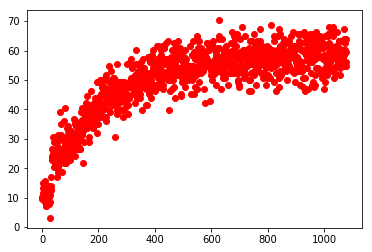

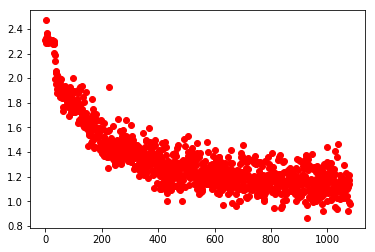

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

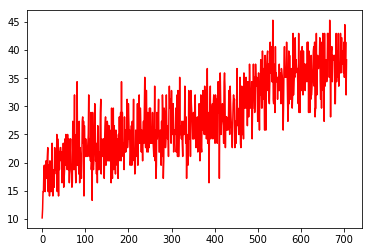

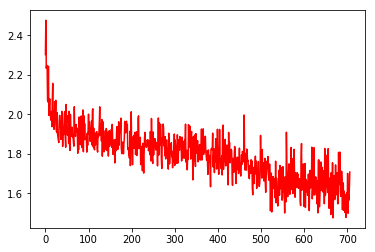

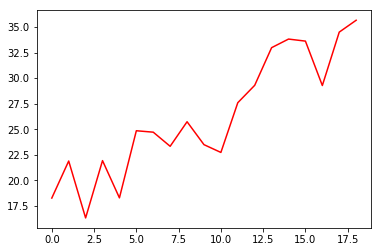

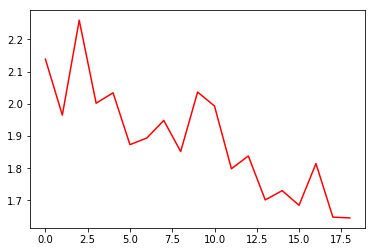

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()